In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification,make_blobs
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
%matplotlib inline

Text(0, 0.5, 'X2')

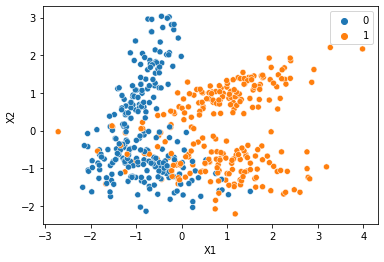

In [26]:
X,y = make_classification(n_features=2,n_samples=500,
                        n_informative=2,
                        n_redundant=0,
                        n_repeated=0,
                        n_classes=2,
                        n_clusters_per_class=2,
                        weights=None,
                        flip_y=0.01,
                        class_sep=.9,
                        hypercube=True,
                        shift=0.0,
                        scale=1.0,
                        shuffle=True,
                        random_state=None,
                    )
sb.scatterplot(x=X[:,0], y=X[:,1], hue=y, ) #For visiulizetion the data
plt.xlabel("X1")
plt.ylabel("X2")

In [27]:
def default_weight(df):
    df["weight"] = 1/df.shape[0]
    return df

In [28]:
def model_train(df):
    X = df.iloc[:,:2]
    y = df.iloc[:,2]
    model = DecisionTreeClassifier(max_depth=1)
    model.fit(X,y)
    return model

In [29]:
def update_row_weights(df,alpha):
    
    pq = []
    for index,row in df.iterrows():
        if row['y'] == row['y_pred']:
            k= row['weight'] * np.exp(-alpha)
        else:
            k= row['weight'] * np.exp(alpha)
        pq.append(k)
    df['update_weight'] = pq
    return df

# df = update_row_weights(df, alpha)


In [30]:
def create_new_dataframe(df):

    indices = []
    for i in range(df.shape[0]):
        a = np.random.random()
        for index,row in df.iterrows():
            if row['upper_range'] > a and a > row['lower_range']:
                indices.append(index)
    return df.iloc[indices, [0,1,2,3]]

In [36]:
class Adaboost:

    def __init__(self,n_trees=1):
        self.n_trees = n_trees
        self.models = []
        self.alphas = []
        
    def fit(self,X,y):
        features = X.shape[1]
        df = pd.DataFrame(X, columns=["X_"+str(i+1) for i in range(features)])
        df['y'] = y
        df = default_weight(df) # default weight 
        for i in range(self.n_trees):
            check_df = df.drop_duplicates()
            if len(check_df)<len(df)*0.125:
                break
            model = model_train(df) # Train Model
            self.models.append(model)
            y_pred = model.predict(X)
            df["y_pred"] = y_pred
            error_weight_sum = df[df['y_pred']!=df['y']]['weight'].sum() # calculate error
            if error_weight_sum==0:
                break
            
            alpha = 0.5*np.log((1-error_weight_sum)/(error_weight_sum+0.000000000001)) # Claculate alpha
            self.alphas.append(alpha)
            
            df = update_row_weights(df, alpha)
            df['update_weight_normal']=df['update_weight']/df.update_weight.sum()
            df["upper_range"] = df.update_weight_normal.cumsum()
            df['lower_range'] = df['upper_range']-df.update_weight_normal
            df = create_new_dataframe(df)
    
    def predict(self,x):
        cou=0
        for i in range(len(self.alphas)):
            cou+=(self.alphas[i]*self.models[i].predict(x))
        return np.sign(cou)
    
    def get_aplhas(self):
        print(self.alphas) # can see all the alpha values 
    
    

In [37]:
model = Adaboost(5)
model.fit(X,y)
y_pred = model.predict(X)


In [38]:
accuracy_score(y, y_pred)

0.882

In [45]:
from sklearn.ensemble import AdaBoostClassifier
sk_model = AdaBoostClassifier(n_estimators=5)
sk_model.fit(X,y)
y_pred = sk_model.predict(X)

In [46]:
accuracy_score(y, y_pred)

0.91

<AxesSubplot:>

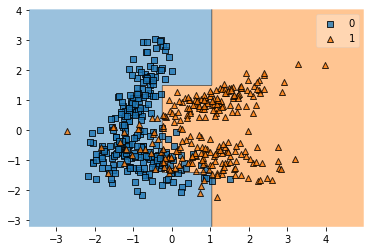

In [47]:
plot_decision_regions(X,y,clf=sk_model)